# OpenABM - User Defined Networks and Demographics

OpenABM comes with a built in demographics model and network models. However, there is an option to generating these outside of the main simualtion and then to run the ABM on them.

## Networks
User defined networks can added by added using the command `model.add_user_network(df_network)` at any time step. They persist and form additional networks to those already in the model. `df_network` is a pandas dataframe with 2 columns `ID_1` and `ID_2` with each row representing an edge on the network. `model.add_user_network()` has the named arguments:
 
1. `interaction_type` - the type of interaction (0=household; 1=occupation; 2=random) which determines transmission multipliers (default: `0`)
2. `skip_hospitalised` - whether to skip this interaction of either person is in hospital (default: `True`)
3. `skip_quarantine` - whether to skip this interaction of either person is in quarantine (default: `True`)
4. `daily_fraction` - fraction of the edges randomly sampled each day (default: `1.0`)
5. `name` - a name associated with the network (default: `"user_network"` )

In the example below we add the ultimate super-spreader who is contact with everybody on the network.


In [1]:
# get a basic model
import example_utils as utils
import pandas as pd
import numpy as np  

n_total = 10000
params  = utils.get_baseline_parameters()
params.set_param( "n_total", n_total )
model = utils.get_simulation( params ).env.model

# now generate a network where everyone is connect to person 0
node_1 = np.array([0]*(n_total-1),  dtype='int32')
node_2 = np.array(range(1,n_total), dtype='int32')
network = pd.DataFrame({'ID_1': node_1, 'ID_2':node_2})
model.add_user_network( network, name = "super_spreader_network")

# run the model for 1 time step
model.one_time_step()

First check that that the super-spreader has formed interactions with everybody.

In [2]:
model.write_interactions_file()
df_inter = pd.read_csv( "interactions_Run1.csv", comment="#", sep=",", skipinitialspace=True )
n_inter  = df_inter.groupby(["ID_1","ID_2"]).size().groupby(["ID_1"]).size().reset_index(name = "n_interactions")
n_inter[n_inter["ID_1"]==0]

,ID_1,n_interactions
0,0,9999


Now run the simulation for 20 time steps and show that person 0 infects a large number of others.

In [3]:
for time in range(20):
    model.one_time_step()
model.write_transmissions()
df_trans = pd.read_csv( "transmission_Run1.csv", comment="#", sep=",", skipinitialspace=True )
n_trans  = df_trans.groupby(["ID_source"]).size().reset_index(name = "n_infected")
n_trans[n_trans["ID_source"]==0]

,ID_source,n_infected
0,0,2104


## Demographics
User defined demographics can be added to the parameter object prior to creating them model using the command `params.set_demographic_household_table( df_demo )`, where `df_demo` is a data frame containing the columns:
   1. `ID` - the index of the person and must be `0` to `n_total-1`.
   2. `house_no` - the house number of the person from `0` to the largest house number. People in the same house must have consecutive `ID`s.
   3. `age_group` - the decade age group of the person and is an integer between `0` (0-9 years) and `8` (80+).
    

In the example below we specify the house numbers and ages for a model with 1000 people (and show just the first 2  households).

In [6]:
del model;
n_total = int(1e3)
params  = utils.get_baseline_parameters()
params.set_param( "n_total", n_total )

# make a simple demographic table
IDs      = np.array( range(n_total), dtype='int32')
house_no = np.array( IDs / 4, dtype='int32' )
ages     = np.array( np.mod( IDs, 9) , dtype='int32' )
df_demo  = pd.DataFrame({'ID':IDs,'age_group':ages,'house_no':house_no})

# add to the parameters and get the model
params.set_demographic_household_table( df_demo ),
model = utils.get_simulation( params ).env.model

df_demo[ df_demo[ "house_no"] < 2]

,ID,age_group,house_no
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,1
5,5,5,1
6,6,6,1
7,7,7,1


Now step forward and check the values being used in the simulation.

In [7]:
model.one_time_step()
model.write_individual_file()
df_indiv = pd.read_csv( "individual_file_Run1.csv", comment="#", sep=",", skipinitialspace=True )
df_indiv[df_indiv["house_no"]<2].loc[:,["ID","age_group","house_no"]]

,ID,age_group,house_no
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,1
5,5,5,1
6,6,6,1
7,7,7,1


And the check the interactions on the household network.

In [13]:
model.write_interactions_file()
df_inter = pd.read_csv( "interactions_Run1.csv", comment="#", sep=",", skipinitialspace=True )
df_inter[(df_inter["type"]==0)&(df_inter["house_no_1"]<2)&(df_inter["ID_1"]< df_inter["ID_2"])].loc[:,["ID_1","ID_2","house_no_1"]]

,ID_1,ID_2,house_no_1
12,0,3,0
13,0,2,0
14,0,1,0
25,1,3,0
26,1,2,0
33,2,3,0
62,4,7,1
63,4,6,1
64,4,5,1
84,5,7,1


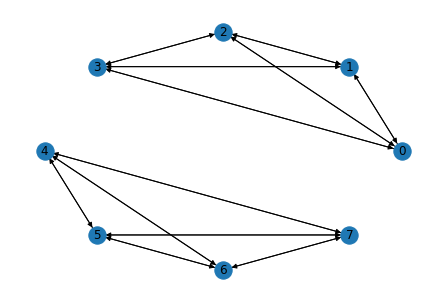

In [14]:
df_inter = df_inter[(df_inter["type"]==0)&(df_inter["house_no_1"]<2)].loc[:,["ID_1","ID_2","house_no_1"]]
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(list(range(max(df_inter["ID_1"])+1)))
for index, row in df_inter.iterrows():
    G.add_edge(row["ID_1"],row["ID_2"])
nx.draw_shell(G, with_labels=True)